In [ ]:
# Import necessary libraries for data handling, image processing, and model building
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Add, DepthwiseConv2D, Reshape, Multiply, Concatenate, Lambda, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras.utils import Sequence

# Specify the path to the Air-Pollution-Image-Dataset-From-India-and-Nepal CSV files after extraction
Provide the file paths for the training, validation, and testing CSV files from the dataset.

In [3]:
# Define file paths for the dataset CSV files
train_csv_file = 'Datasets/train_data.csv'
val_csv_file = 'Datasets/val_data.csv'
test_csv_file = 'Datasets/testing_data.csv'

In [ ]:
class MixupCutmixGenerator(Sequence):
    def __init__(self, generator, alpha=0.4, mode='mixup_cutmix', mix_prob=0.5):
        self.generator = generator
        self.alpha = alpha
        self.mode = mode
        self.mix_prob = mix_prob

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x1, y1 = self.generator[idx]
        x2, y2 = self.generator[np.random.randint(0, len(self.generator))]

        if self.mode == 'mixup_cutmix':
            lam = np.random.beta(self.alpha, self.alpha)
            if np.random.rand() < self.mix_prob:
                return self._mixup(x1, y1, x2, y2, lam)
            else:
                return self._cutmix(x1, y1, x2, y2, lam)
        elif self.mode == 'mixup':
            lam = np.random.beta(self.alpha, self.alpha)
            return self._mixup(x1, y1, x2, y2, lam)
        elif self.mode == 'cutmix':
            lam = np.random.beta(self.alpha, self.alpha)
            return self._cutmix(x1, y1, x2, y2, lam)
        else:
            return x1, y1

    def _mixup(self, x1, y1, x2, y2, lam):
        x = lam * x1 + (1 - lam) * x2
        y = lam * y1 + (1 - lam) * y2
        return x, y

    def _cutmix(self, x1, y1, x2, y2, lam):
        batch_size, h, w, _ = x1.shape
        cut_rat = np.sqrt(1. - lam)
        cut_w, cut_h = int(w * cut_rat), int(h * cut_rat)

        cx = np.random.randint(w)
        cy = np.random.randint(h)

        bbx1 = np.clip(cx - cut_w // 2, 0, w)
        bby1 = np.clip(cy - cut_h // 2, 0, h)
        bbx2 = np.clip(cx + cut_w // 2, 0, w)
        bby2 = np.clip(cy + cut_h // 2, 0, h)

        x1[:, bby1:bby2, bbx1:bbx2, :] = x2[:, bby1:bby2, bbx1:bbx2, :]
        lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1)) / (w * h)
        y = lam_adjusted * y1 + (1 - lam_adjusted) * y2
        return x1, y


In [4]:
def calculate_mean_std(train_csv_file):
    """
    Calculate the mean and standard deviation of the training dataset.
    """
    train_df = pd.read_csv(train_csv_file)
    root_dir = 'Datasets/Images/'
    train_images = [np.array(Image.open(root_dir + img_path).resize((224, 224))) for img_path in train_df['Filename'].values]
    mean = np.mean(train_images, axis=(0, 1, 2)) / 255.0
    std = np.std(train_images, axis=(0, 1, 2)) / 255.0
    return mean, std

mean, std = calculate_mean_std(train_csv_file)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Read the training, validation, and testing CSV files
train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

# Compute class weights to balance the dataset
classes = ['a_Good', 'b_Moderate', 'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 'e_Very_Unhealthy', 'f_Severe']
y_train_labels = train_df['AQI_Class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.array(classes), y=y_train_labels)
index_class_weights = dict(enumerate(class_weights))
print(train_df['AQI_Class'].value_counts())
print(val_df['AQI_Class'].value_counts())
print(test_df['AQI_Class'].value_counts())
print("Class weights:", index_class_weights)

# Define image normalization function using ImageNet statistics
def normalize(image):
    image = image.astype('float32') / 255.0
    image = (image - mean) / std
    return image

# Set the image directory path
path = 'Datasets/Images'

# Configure training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=normalize,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
)

# Configure validation and test data generators without augmentation
val_datagen = ImageDataGenerator(preprocessing_function=normalize)

# Create data generators for training, validation, and testing
train_generator_raw = train_datagen.flow_from_dataframe(
    train_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    seed=42
)

train_generator = MixupCutmixGenerator(train_generator_raw, alpha=0.4, mode='mixup_cutmix', mix_prob=0.5)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical',
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical',
)

AQI_Class
c_Unhealthy_for_Sensitive_Groups    1832
d_Unhealthy                         1678
e_Very_Unhealthy                    1404
b_Moderate                          1006
a_Good                               986
f_Severe                             927
Name: count, dtype: int64
AQI_Class
c_Unhealthy_for_Sensitive_Groups    458
d_Unhealthy                         420
e_Very_Unhealthy                    351
b_Moderate                          252
a_Good                              247
f_Severe                            231
Name: count, dtype: int64
AQI_Class
c_Unhealthy_for_Sensitive_Groups    569
d_Unhealthy                         526
e_Very_Unhealthy                    440
b_Moderate                          314
a_Good                              310
f_Severe                            289
Name: count, dtype: int64
Class weights: {'a_Good': np.float64(1.3240365111561867), 'b_Moderate': np.float64(1.297713717693837), 'c_Unhealthy_for_Sensitive_Groups': np.float64(0.71260917030567

# Build and train a model for AQI class image classification

In [ ]:
from tensorflow.keras import backend as K

def swish(x):
    return x * K.sigmoid(x)

def cbam_block(input_tensor, reduction_ratio=8):
    # ----- Channel Attention -----
    channel = input_tensor.shape[-1]
    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal')
    shared_dense_two = Dense(channel, kernel_initializer='he_normal')

    avg_pool = GlobalAveragePooling2D()(input_tensor)
    max_pool = GlobalMaxPooling2D()(input_tensor)

    avg_pool = shared_dense_one(Reshape((1, 1, channel))(avg_pool))
    avg_pool = shared_dense_two(avg_pool)

    max_pool = shared_dense_one(Reshape((1, 1, channel))(max_pool))
    max_pool = shared_dense_two(max_pool)

    channel_attention = Activation('sigmoid')(Add()([avg_pool, max_pool]))
    x = Multiply()([input_tensor, channel_attention])

    # ----- Spatial Attention -----
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)
    spatial_attention = Concatenate(axis=3)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal')(spatial_attention)

    x = Multiply()([x, spatial_attention])
    return x

def mbconv_block(x, filters, expansion=6, strides=1, enable_cbam=True):
    input_tensor = x
    input_filters = x.shape[-1]
    expanded_filters = input_filters * expansion

    # Expand
    if expansion != 1:
        x = Conv2D(expanded_filters, 1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(swish)(x)

    # Depthwise Convolution
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    if enable_cbam:
        x = cbam_block(x)

    # Project
    x = Conv2D(filters, 1, padding='same')(x)
    x = BatchNormalization()(x)

    # Skip connection if shape match
    if strides == 1 and input_filters == filters:
        x = Add()([x, input_tensor])

    return x

def build_custom_efficientnet(input_shape=(224, 224, 3), num_classes=6, drop_rate=0.3, weight_decay=1e-4):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, strides=2, padding='same', kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    # EfficientNet config (repeats, filters, expansion, stride)
    blocks_config = [
        (1, 32, 1, 1, False),
        (2, 48, 6, 2, False),
        (2, 80, 6, 2, True),
        (3, 112, 6, 2, False),
        (3, 192, 6, 1, True),
        (4, 320, 6, 2, False),
        (1, 640, 6, 1, True),
    ]

    for repeats, filters, expansion, stride, enable_cbam in blocks_config:
        for i in range(repeats):
            s = stride if i == 0 else 1
            x = mbconv_block(x, filters=filters, expansion=expansion, strides=s, enable_cbam=enable_cbam)

    # Head
    x = Conv2D(2560, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_rate)(x)

    x = Dense(512, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_rate)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay))(x)
    return Model(inputs, outputs)

weight_decay = 1e-4
model = build_custom_efficientnet(input_shape=(224, 224, 3), num_classes=6, drop_rate=0.3, weight_decay=weight_decay)


I0000 00:00:1750522907.598010 2211984 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22060 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
# Compile the model with optimizer, loss function, and metrics
import tensorflow as tf
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
def focal_loss(gamma=2., alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = tf.pow(1 - y_pred, gamma)
        if alpha is not None:
            alpha_t = tf.reduce_sum(alpha * y_true, axis=-1)
            weight *= alpha_t[:, None]
        return tf.reduce_mean(tf.reduce_sum(weight * cross_entropy, axis=-1))
    return focal_loss_fixed


initial_learning_rate = 0.0001
optimizer = AdamW(learning_rate=initial_learning_rate, weight_decay=weight_decay)

model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2.0, alpha=np.array(list(index_class_weights.values()))),
    metrics=[
        CategoricalAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

In [8]:
steps_per_epoch = len(train_generator)
val_steps = len(val_generator)

# Train the model with callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=150,
    class_weight=index_class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model.save('model.keras')

/home/jason/Desktop/2025DLProgrammingFinalExam/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1750522922.268732 2212251 service.cc:152] XLA service 0x7cc6400043e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750522922.268747 2212251 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-06-22 00:22:02.868360: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750522925.657203 2212251 cuda_dnn.cc:529] Loaded cuDNN version 90900
2025-06-22 00:22:07.422184: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27261', 20 bytes spill stores, 20 bytes spill loads

2025-06-22 00:22:07.617161: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2117

197/245 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.1952 - loss: 2.2481 - precision: 0.1963 - recall: 0.0751

2025-06-22 00:22:56.840197: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21175', 236 bytes spill stores, 236 bytes spill loads

2025-06-22 00:22:56.847910: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27261', 28 bytes spill stores, 32 bytes spill loads

2025-06-22 00:22:57.069599: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27261', 32 bytes spill stores, 32 bytes spill loads

2025-06-22 00:22:57.162175: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27261', 20 bytes spill stores, 20 bytes spill loads

2025-06-22 00:22:57.605264: I exte

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.1957 - loss: 2.2220 - precision: 0.1956 - recall: 0.0741

2025-06-22 00:23:25.539516: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3440', 12 bytes spill stores, 12 bytes spill loads

2025-06-22 00:23:25.695106: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3440', 104 bytes spill stores, 104 bytes spill loads

2025-06-22 00:23:25.800261: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3440', 4084 bytes spill stores, 4064 bytes spill loads

2025-06-22 00:23:25.950868: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3440', 4020 bytes spill stores, 4012 bytes spill loads

2025-06-22 00:23:26.304694: E 

245/245 ━━━━━━━━━━━━━━━━━━━━ 100s 263ms/step - accuracy: 0.1957 - loss: 2.2215 - precision: 0.1956 - recall: 0.0740 - val_accuracy: 0.1261 - val_loss: 1.6373 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - accuracy: 0.2220 - loss: 1.8883 - precision: 0.2327 - recall: 0.0761 - val_accuracy: 0.1261 - val_loss: 1.5719 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - accuracy: 0.2736 - loss: 1.6763 - precision: 0.3220 - recall: 0.1203 - val_accuracy: 0.1705 - val_loss: 1.4636 - val_precision: 0.3931 - val_recall: 0.0347 - learning_rate: 1.0000e-04
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - accuracy: 0.2826 - loss: 1.5756 - precision: 0.3321 - recall: 0.1254 - val_accuracy: 0.2859 - val_loss: 1.7099 - val_precision: 0.3039 - val_recall: 0.0669 - learning_rate: 1.0000e-04
Epoch 5/100
245/245 ━━━━━━━

# plot your Training Accuracy and validation accuracy here

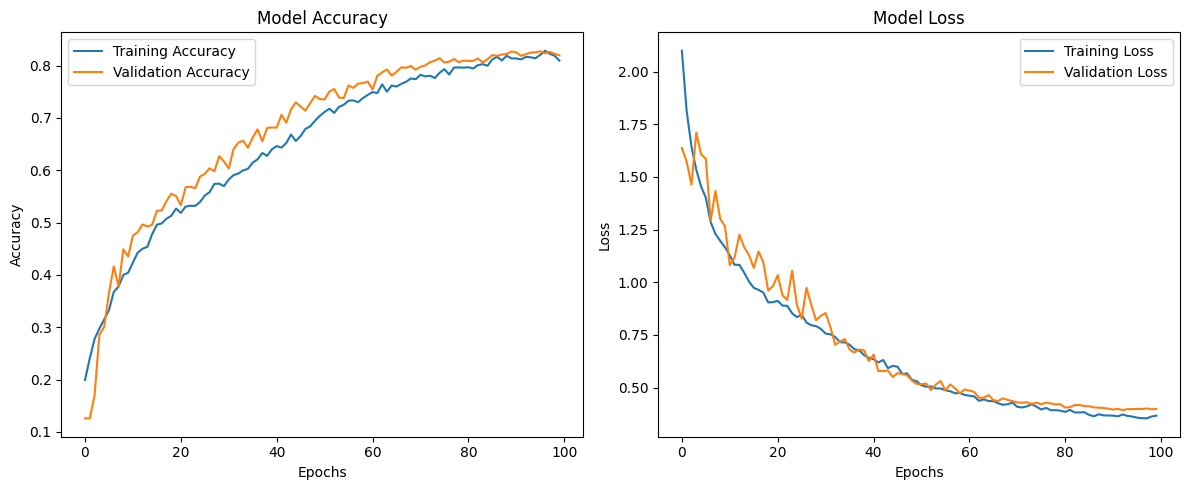

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(history)

# Test your test data and save your result file in this format and upload your solution file on kaggle competition

In [10]:
test_probabilities = model.predict(test_generator, verbose=1)
test_filenames = test_generator.filenames
test_probabilities_df = pd.DataFrame(test_probabilities, columns=['a_Good', 'b_Moderate', 
                                                                  'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 
                                                                  'e_Very_Unhealthy', 'f_Severe'])
test_probabilities_df.insert(0, 'Filename', test_filenames)
test_probabilities_df.to_csv('Outputs/Results.csv', index=False)


75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

2025-06-22 01:24:19.585267: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3314', 4 bytes spill stores, 4 bytes spill loads

2025-06-22 01:24:19.749316: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3314', 116 bytes spill stores, 116 bytes spill loads

2025-06-22 01:24:19.837938: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3314', 3940 bytes spill stores, 3920 bytes spill loads

2025-06-22 01:24:19.983532: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3314', 992 bytes spill stores, 992 bytes spill loads

2025-06-22 01:24:20.441554: E exte

77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step


In [11]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}")

probs = model.predict(test_generator)  # shape = (N, 6)
entropy = -np.sum(probs * np.log(probs + 1e-9), axis=1)

print(f"平均 entropy: {np.mean(entropy):.4f}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8308 - loss: 0.3605 - precision: 0.8846 - recall: 0.7478
Test Loss: 0.36048904061317444, Test Accuracy: 0.8308823704719543, Test Precision: 0.88416987657547, Test Recall: 0.7483659982681274
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
平均 entropy: 0.6858


In [12]:
# Get classification prediction
cls_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(cls_pred, axis=1)

# Get the true labels
y_true = test_generator.classes

# F1 Score per class
from sklearn.metrics import f1_score
f1_scores = f1_score(y_true, y_pred, average=None)
average_f1_score = f1_score(y_true, y_pred, average='macro')

for i, f1 in enumerate(f1_scores):
    print(f"Class {i}: F1 Score = {f1:.4f}")
print(f"Average F1 Score: {average_f1_score:.4f}")


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Class 0: F1 Score = 0.1513
Class 1: F1 Score = 0.1347
Class 2: F1 Score = 0.2114
Class 3: F1 Score = 0.2323
Class 4: F1 Score = 0.1558
Class 5: F1 Score = 0.0964
Average F1 Score: 0.1637


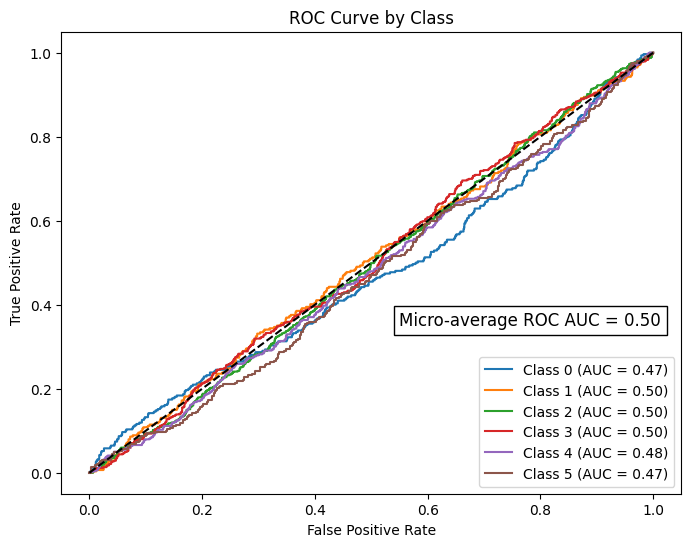

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels
y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))
roc_auc_scores = roc_auc_score(y_true_binarized, cls_pred, average='micro')

# Plot ROC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], cls_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], cls_pred[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(test_generator.class_indices)):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Class')
plt.legend(loc='lower right')
plt.text(0.55, 0.35, f'Micro-average ROC AUC = {roc_auc_scores:.2f}', fontsize=12,
         bbox=dict(facecolor='white', edgecolor='black'))
plt.show()


In [14]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Predict and convert y_true
y_train_pred = np.argmax(model.predict(train_generator), axis=1)
y_val_pred = np.argmax(model.predict(val_generator), axis=1)
y_test_pred = np.argmax(cls_pred, axis=1)

train_mae = mean_absolute_error(train_generator.classes, y_train_pred)
train_rmse = root_mean_squared_error(train_generator.classes, y_train_pred)
val_mae = mean_absolute_error(val_generator.classes, y_val_pred)
val_rmse = root_mean_squared_error(val_generator.classes, y_val_pred)
test_mae = mean_absolute_error(test_generator.classes, y_test_pred)
test_rmse = root_mean_squared_error(test_generator.classes, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}")
print(f"Val MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")


245/245 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step
Train MAE: 1.7055, RMSE: 2.1375
Val MAE: 1.7529, RMSE: 2.1982
Test MAE: 1.7639, RMSE: 2.1944


Training Confusion Matrix:
 [[157 141 180 198 189 121]
 [118 152 231 217 182 106]
 [225 268 412 391 336 200]
 [232 252 353 342 295 204]
 [159 198 308 309 247 183]
 [102 116 202 207 181 119]]
Validation Confusion Matrix:
 [[ 31  39  43  57  43  34]
 [ 26  49  59  55  37  26]
 [ 50  73  95 106  70  64]
 [ 38  77  89  84  77  55]
 [ 50  54  74  67  70  36]
 [ 35  41  48  48  39  20]]
Testing Confusion Matrix:
 [[ 46  42  55  70  54  43]
 [ 34  46  59  74  60  41]
 [ 69  88 115 139  92  66]
 [ 65  75 100 125 101  60]
 [ 52  72 114  81  67  54]
 [ 32  46  76  61  46  28]]


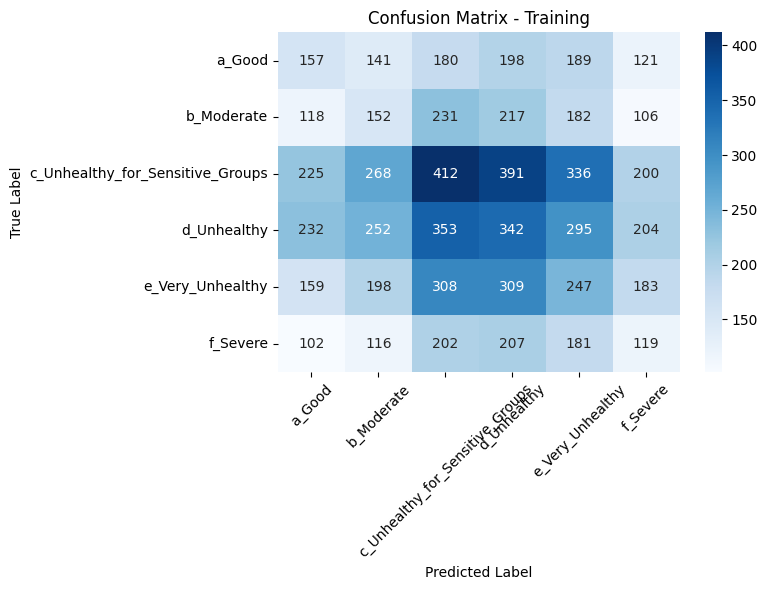

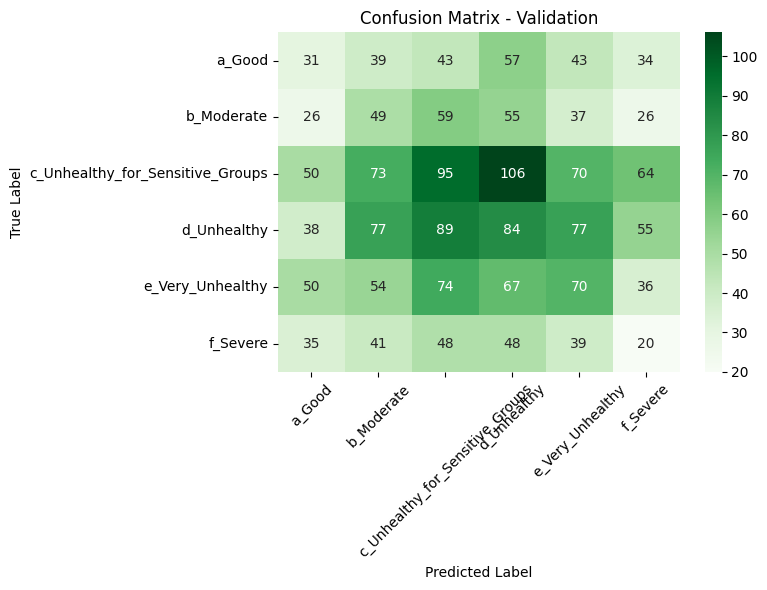

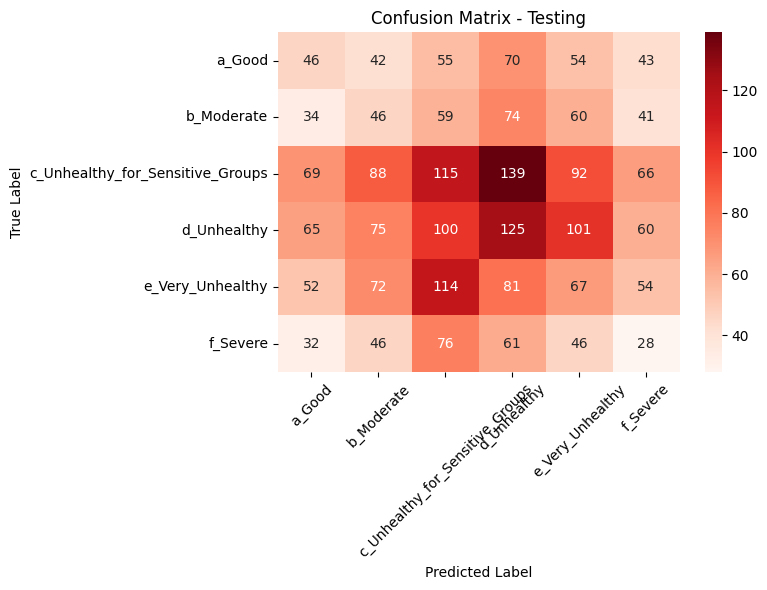

In [15]:
import seaborn as sns

class_labels = list(test_generator.class_indices.keys())

# Confusion matrices
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(train_generator.classes, y_train_pred)
val_cm = confusion_matrix(val_generator.classes, y_val_pred)
test_cm = confusion_matrix(test_generator.classes, y_test_pred)

print("Training Confusion Matrix:\n", train_cm)
print("Validation Confusion Matrix:\n", val_cm)
print("Testing Confusion Matrix:\n", test_cm)

# Training
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Validation
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Testing
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Testing')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
